<h1 style="text-align: center" >Springboard Capstone Project: Milestone Report

<h3 style="text-align: center" >DP Rooney
<h3 style="text-align: center" >August 11, 2016

## Introduction and Background


There has been considerable growth in advanced statistics for professional hockey in the last few years. Traditionally, shots on goal has been an important statistic, but this has expanded to consider Fenwick stats (shots on goal + shots missed) and Corsi stats (shots on goal + shots missed + shots blocked). Corsi stats are also called shot attempts. Additionally, instead of looking at the shot the player himself attempts, one considers the on-ice statistics. That is, the shot attempts that occur when he is on the ice, both for his team, and against his team. One can define the "Corsi-for percentage", or CF%, as follows:

$$\textrm{ CF\%(player X) } = \frac{\textrm{No. shot attempts for X's team | X on-ice}}{\textrm{No. shot attempts for both teams | X on-ice }} $$

This stat evaluates how a player contributes to producing shot attempts for his team while preventing shot attempts against his team. Some of the attractive features of this statistic are:

1. It combines offensive and defensive merit, so that players with flashy scoring and frequent defensive lapses are not over-rated.
2. It credits players that contribute indirectly to an offensive play, such as with canny passes from the defensive zone, tight fore-checking, smart spacing.
3. It eliminates some of the randomness inherent to turning shot attempts into goals.
4. The data set is larger (there are around twice as many shot attempts as shots on goal per game).

One major drawback with this stat is that it does not take into account the quality of opposition. A fundamental phenomenon in hockey is line-matching. Each team has four different forward-lines (and three defense-pairings) that generally differ in abilities, and coaches will strategize as how to optimize the match-ups between opposing lines. For example, a good defensive forward line will often be matched against the opposition's best offensive line. Therefore, comparing the CF% of a first-line and a fourth-line player is unfair to the better player, since he has to work harder to generate a shot attempt, and prevent opposing shot attempts.

For example, this reddit post points out that Jake Virtanen, a young, raw prospect for the Vancouver Canucks, has a better CF% than Jonathan Toews, who is seen as one of the best players in the league:

https://www.reddit.com/r/canucks/comments/4omaqp/why_jake_virtanen_is_better_than_jonathan_toews/

While Virtanen may develop into one of the best players in the league, it is unlikely that his performance was on par with Toews' last season.

The goal of my project is to develop a model that is more nuanced. Instead of modeling the ratio of shot-attempts as a function of a single player, we will consider the probability of shot-attempts as a function of all players on the ice. In other words, we want to model the probability

$$P(\textrm{ next SA is for home-team } | \textrm{ home-players } X_1, … X_6 \textrm{ on-ice; away-players } Y_1, …, Y_6 \textrm{ on-ice } )$$

My prospective client would be the management of a hockey team that wants to evaluate players in ways that go past the common wisdom. It may want to track the performance of its own players, and also evaluate players that are becoming free agents in the off-season. A predictive model that describes shot-attempt probability relative to opposing players would allow a team to directly compare players and assess their relative value.

## Scraping and Wrangling

The data was scraped from three types of game reports from the NHL: game rosters, event summaries and play-by-play reports. The URL's for the first game are here:

http://www.nhl.com/scores/htmlreports/20152106/RO020001.HTM

http://www.nhl.com/scores/htmlreports/20152106/ES020001.HTM

http://www.nhl.com/scores/htmlreports/20152106/PL020001.HTM

The two-letter codes RO, ES and PL indicate the report type, and the last four digits of the six digits indicates the number (the first two digits distinguish pre-season (01), regular season (02) and post-season (03)). There are 1230 game in the 2015-2016 regular season (30 teams and 82 games each). These reports are all in pure HTML (no CSS or JSON), so I had to go through a lot of nested ```<table>```'s to get the necessary data.

My Python code for scraping this data falls into six files:

In [1]:
import os
import numpy as np
import scipy.stats as sps 
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib
%matplotlib inline

import matplotlib.pyplot as plt


os.listdir('scraping')

Using matplotlib backend: TkAgg


['report_downloader.py',
 'directory_build.py',
 'roster_scrape.py',
 '.ipynb_checkpoints',
 'attempt_scrape.py',
 'salary_fill.py',
 'es_scrape.py']

An overview of the code in these files:

1. The file `roster_scrape.py` contains code for scraping the roster reports. It includes a class `RosterParse` which extracts the forty players that dressed (eighteen players and two goalies for each team). This includes their team, the player name, the position (center, left wing, right wing, defense or goalie) and their jersey number. A second class, `RosterBuilder` assembled rosters for all 1230 games and saved them in a 49,200 line file `Big_Roster.csv`. 

2. The file `directory_build.py` contains code for consolidated the big roster into a player directory. It includes a class `SalaryParse` that extracts the salary for each player from the web-site www.capfriendly.com. The class `DirectoryBuilder` constructs the player directory and adds the salary information. The player directory contains 1,011 players, of which 111 are goalies.

3. The file `salary_fill.py` contains code for filling in some missing salary information that was not immediately available from CapFriendly. 25 players did not have 2015-2016 salaries available, so I used their 2016-2017 salaries. Salaries are only being used to estimate perception of player quality, so using salary from two different years is not such a big deal.

4. The file `report_downloader.py` contains code for downloading the play-by-play and event summary reports. I used this because I wanted to work on scraping while off-line.

5. Besides salary information, I also wanted to use time-on-ice (TOI) information. The file ```es_scrape.py``` includes code for doing this. It includes a class `EventParse` that looks at the event-summary reports and extracts TOI for each player for each game, and a class `TOIBuilder` which totals season TOI and adds it to the player directory. It also includes a function `Dir_process` which adds a column `paTOI/G` to the directory. This statistic is the per-game TOI for each player, multiplied by 0.75 if the player is a defensemen. Because there are 3 defense lines to 4 forward lines, defensemen play approximately 4/3 as much, so TOI/G should be adjusted.

6. The file `attempt_scrape.py` contains code for extracting the shot-attempt data for each game and saving it as a table. These table include 14 columns: the event (shot, missed shot, goal, blocked shot), a boolean stating whether the attempt was for the home teams, the jersey numbers for the six home player and six away players (some of which would be listed as `None` if there were penalties).

There is still work to be done however. In a separate folder, I have code for wrangling:

In [7]:
os.listdir('wrangling')

['attempt_manager.py',
 'attempt_manager.pyc',
 '.ipynb_checkpoints',
 '__init__.pyc',
 'data_split.py',
 'summary_manager.py',
 '__init__.py']

I'll talk about `data_split.py` in a bit. The other two files:

1. `attempt_manager.py` is responsible for consolidating the shot-attempt data into one data set. It contains a class `attempt_manager` that does this. It saves a number of objects into the file `Attempts.npz`. First and foremost, it contains a 0-1 sparse matrix (a `csc_matrix` object from the module `scipy.sparse`) with 1800 columns and 136,530 rows. Each row represents one shot attempt, and each column represents one player, and each element is `True` if and only if that player was on the ice for that shot attempt. There are 1800 columns because there are 900 players (we exclude the goalies) and we consider a player at-home to be distinct from a player away-from-home, so columns 1-900 are home players and 901-1800 away players. 

    The sparse matrix is our main data set, but some other objects are also contained in the file:
    * the list of non-goalie names so that we can match the columns to players
    * game counts: the number of shot attempts in each game
    * a list of indices indicating which of the shot attempts was for the home team. This is our indicator variable.
    * a list of attempt type (whether an attempt was a goal, shot, missed shot, or blocked shot).
    * four lists indicating the average salary and average playing time of the players on-ice for the home and away sides

    The class also contains a method `compute_Corsi` which computes the season CF for any player.

2. The file `summary_manager.py` is for looking at attempt data on a game-by-game basis. It includes a class `summary_manager` which adds the goals, shots, missed shots, blocked shots and total shot attempts for each team in each game and saves it in the file `Summary.csv` as a 1230 by 10 table.

## A first look at the data

Two proxy statistics we can use to assess 'quality of opponent' (or at least the perception of quality) are player salary and player playing time. Salary is a little problematic, because younger players are certainly underpaid, and the production of older players can fall off after getting a fat contract. The latter statistic is probably better, because a coach can respond quickly to changes in playing quality, and because there is a decent spread in player time on ice (TOI):

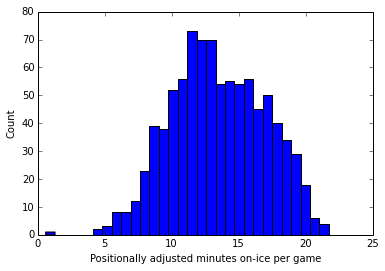

In [17]:
players = pd.read_csv('data/Directory.csv')
players=players[ ~players.TOI.isnull()]
plt.hist( list(players['paTOI/G']),bins=30)
plt.xlabel('Positionally adjusted minutes on-ice per game')
plt.ylabel('Count')
plt.show()

Here is the breakdown of shot attempts and players:

In [18]:
import wrangling.attempt_manager as am

AM = am.attempt_manager()
AM.Load()
print 'Number of non-goalies that dressed in 2015-16: {}'.format(len(AM.NGs))

t_dict = {'G': 'Goals', 'S': 'Shots saved', 'M': 'Shot missed', 'B': 'Shots blocked'}
for k in t_dict.keys():
    print t_dict[k] + ': ' + str(AM.attempt_type.count(k))
print 'Total shot attempts: {}'.format( AM.no_att ) 

Number of non-goalies that dressed in 2015-16: 900
Shots saved: 66601
Shots blocked: 34845
Shot missed: 28519
Goals: 6565
Total shot attempts: 136530


We can see there is a home-ice advantage: 

In [19]:
print 'Home goals: {}'.format( sum( pd.Series( AM.attempt_type)[AM.home_indices] == 'G') )
print 'Away goals: {}'.format(AM.attempt_type.count('G') - sum( (pd.Series( AM.attempt_type)[AM.home_indices] == 'G') ))

print 'Home shot attempts: {}'.format(len(AM.home_indices))
print 'Away shot attempts: {}'.format( AM.no_att - len(AM.home_indices) )

Home goals: 3404
Away goals: 3161
Home shot attempts: 70468
Away shot attempts: 66062


If playing time and salary are both good measures of player quality, we should expect them to correlate:

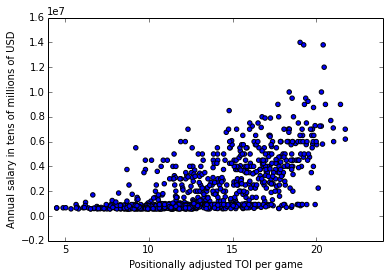

In [20]:
plt.scatter(players['paTOI/G'],players['Salary'])
plt.xlim(4,24)
plt.xlabel('Positionally adjusted TOI per game')
plt.ylabel('Annual salary in tens of millions of USD')
plt.show()

We see a clear correlation, although we can see a subgroup that is rather flat at the bottom. As it happens, entry-level contracts are capped at 925,000 USD, so that subgroup represents the underpaid young players. 

To support our claim that better players tend to share the ice with other better players, we consider the average salary and playing time for home players versus away players. ```attempt_manager``` has class variables recording this data.

Visually it's difficult to tell whether there's a good correlation, especially with respect to salary:

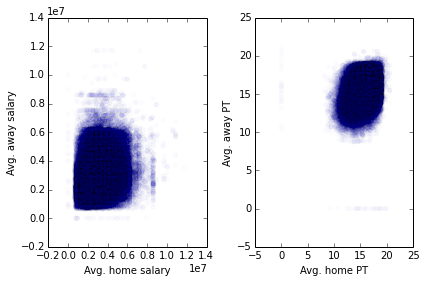

In [29]:
h_sal = pd.Series(AM.home_OI_sal)
a_sal = pd.Series(AM.away_OI_sal)
h_PT = pd.Series(AM.home_OI_PT)
a_PT = pd.Series(AM.away_OI_PT)

fig, ax = plt.subplots(1,2)
ax[0].scatter(h_sal,a_sal, alpha=0.01)
ax[0].set_xlabel('Avg. home salary')
ax[0].set_ylabel('Avg. away salary')

ax[1].scatter(h_PT,a_PT, alpha=0.01)
ax[1].set_xlabel('Avg. home PT')
ax[1].set_ylabel('Avg. away PT')
plt.tight_layout()

If we run a linear regression however, we can see that, after proper scaling, there is a moderate salary correlation:

In [16]:
h_sal_norm = (h_sal-h_sal.mean())/h_sal.std()
a_sal_norm = (a_sal-a_sal.mean())/a_sal.std()

LR = LinearRegression()
LR.fit(h_sal_norm.reshape(-1,1),a_sal_norm.reshape(-1,1))
print LR.intercept_, LR.coef_

[  1.27271388e-14] [[ 0.14216014]]


And when we do the same to the playing time data, we get a correlation coefficient of 0.30. This is around what I would expect: a definite correlation, but enough 'cross-talk' between various lines that we get good players on the ice with not-so-good players at a reasonable clip.

In [17]:
h_PT_norm = (h_PT-h_PT.mean())/h_PT.std()
a_PT_norm = (a_PT-a_PT.mean())/a_PT.std()

LR = LinearRegression()
LR.fit(h_PT_norm.reshape(-1,1),a_PT_norm.reshape(-1,1))
print LR.intercept_, LR.coef_

[ -3.04233575e-14] [[ 0.29567157]]


We can now ask whether these two metrics affect shot attempts:

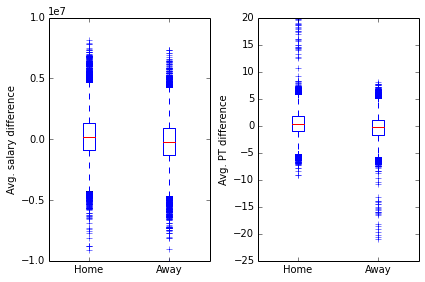

In [19]:
away_indices = list(set(range(0,len(AM.attempt_type))) - set(AM.home_indices))
away_indices.sort()
sal_diff = pd.DataFrame()
sal_diff_home = list(pd.Series(AM.home_OI_sal)[AM.home_indices]- pd.Series(AM.away_OI_sal)[AM.home_indices])
sal_diff_away = list(pd.Series(AM.home_OI_sal)[away_indices]- pd.Series(AM.away_OI_sal)[away_indices])
PT_diff_home = pd.Series(AM.home_OI_PT)[AM.home_indices]- pd.Series(AM.away_OI_PT)[AM.home_indices]
PT_diff_away = pd.Series(AM.home_OI_PT)[away_indices]- pd.Series(AM.away_OI_PT)[away_indices]

fig, ax = plt.subplots(1,2)
ax[0].boxplot([sal_diff_home,sal_diff_away])
ax[1].boxplot([PT_diff_home,PT_diff_away])
ax[0].set_ylabel('Avg. salary difference')
ax[1].set_ylabel('Avg. PT difference')
for j in [0,1]:
    ax[j].set_xticklabels(['Home','Away'] )
plt.tight_layout()

It is clear that effect size is actually quite small, and in the case of salary, there may not be any effect at all. Despite the very significant overlap in both cases, our sample size is very large, so we may get very large z-statistics anyway. 

In [21]:
sal_diff_mean_diff = np.mean(np.array(sal_diff_home)) - np.mean(np.array(sal_diff_away))
sal_diff_var_home = np.var(np.array(sal_diff_home))
sal_diff_var_away = np.var(np.array(sal_diff_away))
nh = len(sal_diff_home)
na = len(sal_diff_away)
sal_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*sal_diff_var_home + nh*sal_diff_var_away)/ float(nh+na-2))

z_statistic = sal_diff_mean_diff / sal_diff_error
print 'Difference in salary discrepancy between home and away shot attempts: {}'.format(sal_diff_mean_diff)
print 'The z-score is: {}'.format(z_statistic)
print 'The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic))

Difference in salary discrepancy between home and away shot attempts: 426308.743591
The z-score is: 44.9592485704
The probability that this is just a fluke is: 0.0


In [22]:
PT_diff_mean_diff = np.mean(np.array(PT_diff_home)) - np.mean(np.array(PT_diff_away))
PT_diff_var_home = np.var(np.array(PT_diff_home))
PT_diff_var_away = np.var(np.array(PT_diff_away))
nh = len(PT_diff_home)
na = len(PT_diff_away)
PT_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*PT_diff_var_home + nh*PT_diff_var_away)/ float(nh+na-2))

z_statistic = PT_diff_mean_diff / PT_diff_error
print 'Difference in playing time discrepancy between home and away shot attempts: {}'.format(PT_diff_mean_diff)
print 'The z-score is: {}'.format(z_statistic)
print 'The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic))

Difference in playing time discrepancy between home and away shot attempts: 0.665294931899
The z-score is: 57.9543230745
The probability that this is just a fluke is: 0.0


Both of the effect sizes (average salary bump of $436,000 and playing time bump of 36 seconds per 60 minutes) are rather small but definitely not trivial. Additionally, the large sample sizes allow us to conclude that these effects are very significant. If salary and playing time are good indicators of player ability, then the ability of players on the ice affects frequency of shot attempts. 

We have already mentioned that playing time is probably a better indicator of player ability than salary. Moreover, both variables are correlated, so is it necessary to consider both? More variables lead to overfitting and we don't want two features when only one is needed. 

Now, one can imagine reasons why salary could still be useful. Some older players may be quite skilled but with lower stamina. Therefore they may be well compensated, but given less playing time. A more important effect is that players on bad teams get more playing time than they deserve, because their competition is limited. Presumably their salary would not reflect this lower competition. Conversely, players on loaded teams may be well-paid to reflect their ability, but may see less ice-team because their teammates are good. This effect is probably mitigated considerably by the salary cap, but let us examine the data.

Let's create a third feature by projecting away PT from the salary data:

In [23]:
numerator1 = np.matrix(AM.home_OI_sal).dot(np.matrix(AM.home_OI_PT).T )[0,0]
denom1 = np.matrix(AM.home_OI_PT).dot(np.matrix(AM.home_OI_PT).T )[0,0]
adj_sal_home = np.matrix(AM.home_OI_sal) - numerator1/denom1 * np.matrix(AM.home_OI_PT)

numerator2 = np.matrix(AM.away_OI_sal).dot(np.matrix(AM.away_OI_PT).T )[0,0]
denom2 = np.matrix(AM.away_OI_PT).dot(np.matrix(AM.away_OI_PT).T )[0,0]
adj_sal_away = np.matrix(AM.away_OI_sal) - numerator2/denom2 * np.matrix(AM.away_OI_PT)

adj_sal_diff_home = np.array(adj_sal_home)[0][AM.home_indices] - np.array(adj_sal_away)[0][AM.home_indices]
adj_sal_diff_away = np.array(adj_sal_home)[0][away_indices] - np.array(adj_sal_away)[0][away_indices]

adj_sal_diff_mean_diff = np.mean(adj_sal_diff_home) - np.mean(adj_sal_diff_away)
adj_sal_diff_var_home = np.var(adj_sal_diff_home)
adj_sal_diff_var_away = np.var(adj_sal_diff_away)
nh = len(adj_sal_diff_home)
na = len(adj_sal_diff_away)
adj_sal_diff_error = np.sqrt( 1/ float(nh)+1/float(na)) * np.sqrt( (nh*adj_sal_diff_var_home + nh*adj_sal_diff_var_away)/ float(nh+na-2))

z_statistic = adj_sal_diff_mean_diff / adj_sal_diff_error
print 'Difference in adjusted salary discrepancy between home and away shot attempts: {}'.format( adj_sal_diff_mean_diff)
print 'The z-score is: {}'.format(z_statistic)
print 'The probability that this is just a fluke is: {}'.format(1-sps.norm.cdf(z_statistic))

Difference in adjusted salary discrepancy between home and away shot attempts: 285534.784257
The z-score is: 34.9461561288
The probability that this is just a fluke is: 0.0


So, the adjustment decreases the effect size, by slightly less than half. Yet the confidence in a significant result is still extremely high. The large sample size has lot to do with this, but as of now, the data indicates we should keep both variables.

## Basic models

The first step is to use a logistic regression. We will look at three simple models:

1. A logistic regression that just uses the Corsi numbers of the home and away players. The correct features are not the CF% numbers themselves, but the logarithms thereof. Additionally, we are not going to use the *averages*, but the sum. The reason is that power play situations mean that the number of players on-ice are not constant, and this certainly affects the shot attempts. Therefore, our first two variables are $x_1 = \sum_{i, X_i \textrm{ on-ice }} \log(CF\%(X_i))$ and $x_2 = \sum_{i, Y_i \textrm{ on-ice }} \log(CF\%(Y_i))$, where $X_i$ and $Y_i$ represent home and away players, respectively. 
    
2. A logistic regression that adds two more variables: $x_3$ and $x_4$, the average playing-time of the home on-ice players and the away on-ice players.

3. A logistic regression that adds another two variables: $x_5$ and $x_6$, the average salary of the home on-ice players and the away on-ice players.

First, to properly evaluate our models, we need to make a training / cross-validation split. We have some code in the file `data_split.py` that does this. Sixty percent of our data set is sent to the file `Training.npz` to be use to train our algorithm. The split is done randomly (and seeded properly). The remaining data are split evenly and sent to `CPV.npz` and `Test.npz`.  

After we obtain our training set, we must reduce our data set to the six desired features. We have code in the file `feature_assemble.py` that accomplishes this. It contains a class `FeatureAssemble`, which includes methods `Corsis()` and `Assemble()`. The former computes the CF% stats, but only using the shot attempts in the training set, and the latter constructs a table containing $x_1$ through $x_6$. 

One practical issue that should be noted: since we are using log-likelihoods, any CF% that is 0 or 100 will cause an error. This is not an issue for most players, but for players that have little data available, we must use a fudge factor $\epsilon$, and insist that every player is on the ice for at least $\epsilon$ shot attempts in either direction. In our code we use $\epsilon=0.1$, so that a player that is on the ice for only one shot attempt has a $CF\%$ of either 9.09% or 90.9%. This also means a player who sees zero shot attempts has a CF% of exactly 50%.

Now that we have constructed our data, we code a logistic classifier object `small_logistic`, contained in the file `small_logistic.py`. This object first scales the data (this is important, as salary is much larger in scale than playing time), and then fits the data three times. First using only $x_1$ and $x_2$, second adding $x_3$ and $x_4$, and third adding $x_5$ and $x_6$. It can also compute the prediction score and cross-entropy of the trained classifier on both the training and cross-validation data. We use another object called `SL_sweeper` that varies the regularization strength (actually the parameter is $C$, the inverse of the regularization strength):

In [3]:
import small_logistic.small_logistic as slr

C = [ pow(10, c/2.) for c in range(-10,10)]
SLS = slr.SL_sweeper(C)
SLS.training()

/usr/local/lib/python2.7/dist-packages/sklearn/utils/optimize.py:193: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


(ignore the warning)

Now that we have trained the algorithm, we can display the learning curves. The four graphs below show the prediction score (left) and cross-entropy (right) as $C$ varies, for all three methods. The lower graphs are identical to upper graphs, but with the vertical scale magnified, so that we can see the separation of the three algorithms: 

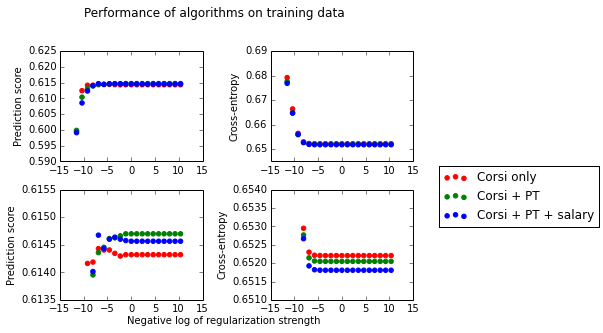

In [82]:
fig2, ax2 = plt.subplots(2,2 )

ax2[0,0].scatter(np.log(C), SLS.eval_matrix[ 'Corsis', 'Training', 'Scores'], color='red', label='Corsi only' )
ax2[0,0].scatter(np.log(C), SLS.eval_matrix[ 'plus_PT', 'Training', 'Scores'], color='green', label='Corsi + PT' )
ax2[0,0].scatter(np.log(C), SLS.eval_matrix[ 'all', 'Training', 'Scores'], color='blue' , label= 'Corsi + PT + salary')
ax2[0,1].scatter(np.log(C), SLS.eval_matrix[ 'Corsis', 'Training', 'Cross entropy'], color='red' )
ax2[0,1].scatter(np.log(C), SLS.eval_matrix[ 'plus_PT', 'Training', 'Cross entropy'], color='green' )
ax2[0,1].scatter(np.log(C), SLS.eval_matrix[ 'all', 'Training', 'Cross entropy'], color='blue' )
ax2[1,0].scatter(np.log(C), SLS.eval_matrix[ 'Corsis', 'Training', 'Scores'], color='red' )
ax2[1,0].scatter(np.log(C), SLS.eval_matrix[ 'plus_PT', 'Training', 'Scores'], color='green' )
ax2[1,0].scatter(np.log(C), SLS.eval_matrix[ 'all', 'Training', 'Scores'], color='blue' )
ax2[1,0].set_ylim([.6135,.6155])
ax2[1,1].scatter(np.log(C), SLS.eval_matrix[ 'Corsis', 'Training', 'Cross entropy'], color='red' )
ax2[1,1].scatter(np.log(C), SLS.eval_matrix[ 'plus_PT', 'Training', 'Cross entropy'], color='green' )
ax2[1,1].scatter(np.log(C), SLS.eval_matrix[ 'all', 'Training', 'Cross entropy'], color='blue' )
ax2[1,1].set_ylim([.651,.654])
h, l = ax2[0,0].get_legend_handles_labels()
fig2.legend(h,l, bbox_to_anchor=(1.4,0.6) )
for j in [0,1]:
    ax2[j,0].set_ylabel('Prediction score')
    ax2[j,1].set_ylabel('Cross-entropy')
fig2.text(.3,0,'Negative log of regularization strength')
fig2.suptitle('Performance of algorithms on training data', fontsize=12, y = 1.1)
plt.tight_layout()


Here is how the algorithms fare on the cross-validation data:

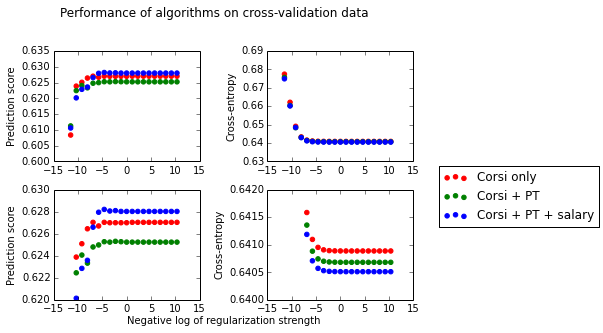

In [104]:
fig3, ax3 = plt.subplots(2,2)
ax3[0,0].scatter(np.log(C), SLS.eval_matrix[ 'Corsis', 'CV', 'Scores'], color='red', label='Corsi only' )
ax3[0,0].scatter(np.log(C), SLS.eval_matrix[ 'plus_PT', 'CV', 'Scores'], color='green', label='Corsi + PT' )
ax3[0,0].scatter(np.log(C), SLS.eval_matrix[ 'all', 'CV', 'Scores'], color='blue' , label= 'Corsi + PT + salary')
ax3[0,1].scatter(np.log(C), SLS.eval_matrix[ 'Corsis', 'CV', 'Cross entropy'], color='red' )
ax3[0,1].scatter(np.log(C), SLS.eval_matrix[ 'plus_PT', 'CV', 'Cross entropy'], color='green' )
ax3[0,1].scatter(np.log(C), SLS.eval_matrix[ 'all', 'CV', 'Cross entropy'], color='blue' )
ax3[1,0].scatter(np.log(C), SLS.eval_matrix[ 'Corsis', 'CV', 'Scores'], color='red' )
ax3[1,0].scatter(np.log(C), SLS.eval_matrix[ 'plus_PT', 'CV', 'Scores'], color='green' )
ax3[1,0].scatter(np.log(C), SLS.eval_matrix[ 'all', 'CV', 'Scores'], color='blue' )
ax3[1,0].set_ylim([.62,.63])
ax3[1,1].scatter(np.log(C), SLS.eval_matrix[ 'Corsis', 'CV', 'Cross entropy'], color='red' )
ax3[1,1].scatter(np.log(C), SLS.eval_matrix[ 'plus_PT', 'CV', 'Cross entropy'], color='green' )
ax3[1,1].scatter(np.log(C), SLS.eval_matrix[ 'all', 'CV', 'Cross entropy'], color='blue' )
ax3[1,1].set_ylim([.64,.642])
h, l = ax3[0,0].get_legend_handles_labels()
fig3.legend(h,l, bbox_to_anchor=(1.4,0.6) )
for j in [0,1]:
    ax3[j,0].set_ylabel('Prediction score')
    ax3[j,1].set_ylabel('Cross-entropy')
fig3.text(.3,0,'Negative log of regularization strength')
fig3.suptitle('Performance of algorithms on cross-validation data', fontsize=12, y = 1.1)

plt.tight_layout()


If we pick the algorithm that performs best, and choose the best $C$, these are our performance metrics:

In [105]:
best_C = SLS.eval_matrix['all','CV','Cross entropy'].argmin()
SLS.eval_matrix.loc[best_C,'all']

split     metric       
Training  Scores           0.6145658
          Cross entropy    0.6518095
CV        Scores           0.6280305
          Cross entropy    0.6405135
Name: 3162.27766017, dtype: object

Some observations:

1. We must admit that the improvement we get by adding salary and PT is very small (so small that we needed to magnify). Ultimately, this has to be somewhat disappointing.
2. The prediction score using just the Corsi numbers however is not that bad. This is an inherently noisy process, so we do not expect do get anywhere near to even 90% prediction score. Getting above 60% is rather satisfying. Clearly, we have some predictive power.
3. Judging by cross-entropy on the training and cross-validation sets, adding PT improves our model, and adding salary improves it even more. Interestingly, these improvements do not necessarily carry over to the prediction score. Adding salary hurts the prediction score on the training set, while on the cross-validation set, the Corsi + PT model performs the worst! Ultimately, we have to judge our model on cross-entropy rather than prediction score.
4. Strangely, our metrics are slightly better on the cross-validation data! Presumably, this is because of a smaller data set (although of course we are using average cross-entropy).
5. The cross-validation learning curves do not really a show an optimum: the performance does not suffer by eliminating regularization.

We can conclude from 4. and 5. that we are definitely not over-fitting our algorithms. Combining that with the disappointing improvement indicates we need to implement more powerful models. 

## The next steps

The models described so far are quite basic, and more sophistication is required. I intend to do use two more algorithms to improve my predictions:

1. A force-equilibrium model. Assume that player $j$ has an adjusted Corsi likelihood $r_j$, and let $S_{jk}$ be the number of shot attempts for player $k$'s team while players $j$ and $k$ are on the ice against each other. Imagine this data exerts a "force" on $r_j$ proportional to the shot attempt numbers that adjusts the likelihoods in the proper direction. This sets up a set of differential equations:

    \begin{align}
    \frac{dr_j}{dt} &= -S_{kj}r_j + \sum_{k\ne j}  S_{jk}r_k
    \end{align}
    
    We then adjust $r_j$ to be the equilibrium solution of these equations (i.e. all forces are zero). This is inspired by the principle of detailed balance that Einstein used to describe quantum emission and absorption of photons.
    
    For example, if there are only two players, the solution (up to a multiplicative constant) is $r_1 = \frac{S_{21}}{S_{12}}$ and $r_2=\frac{1}{r_1}$. This is clearly the most parsimonious way: the corresponding probability would be $\frac{S_{12}}{S_{12}+S_{21}}$ and $\frac{S_{21}}{S_{12}+S_{21}}$, which of course are the usual CF numbers.
    
    But let us add a third player. Suppose players 1 and 2 play each other and there five shot attempts for each team. Then players 1 and 3 play each other and there are nine shot attempts for player 1's team and one for player 3's team. The CF percentages end up being 70\%, 50\% and 10\%. However, the numbers indicate that players 1 and 2 are even. If we feed these numbers into the differential equations above and solve, we get $r_1 = r_2 = \frac{27}{19}$ and $r_3 = \frac{3}{19}$. This is leads to probabilities 58.7\%, 58.7\% and 13.6\%, which appear to be more sensible.
    
    Once I have computed these likelihoods $r_j$, I can use them in a new logistic regression model to predict shot attempts on the cross-validation set.

2. Logistic regression and possibly neural networks on the entire training set. Instead of using six features as above, I can use all 1800 features that exist in the data set. With this many features, over-fitting is a concern, so attention must be given to the learning curves. 